## AB-тест

Предположим, что наш продукт это мобильное приложение. База данных ClockHouse. Все пользователи деляться на группы для проведения экспериментов. Необходимо проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил  с 2022-01-28 по 2022-02-03 включительно. Для эксперимента были задействованы 0 и 1 группы. 

In [1]:
# импортируем нужные для работы библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse as ph
from scipy import stats
import numpy as np

In [2]:
# подключимся к базе данных
connection = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'simulator_20220120',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

query = "select user_id, countIf(user_id, action = 'like') as like, \
countIf(user_id, action = 'view') as view, like/view as ctr, \
exp_group from {db}.feed_actions where (toDate(time) between '2022-01-28' and '2022-02-03') \
and exp_group in (0, 1) group by user_id, exp_group"
df = ph.read_clickhouse(query, connection=connection)

В 1 группе был использован новый алгоритм рекомендации постов, 0 группа использовалась в качестве контроля. 

Нулевая гипотеза будет звучать так: "CTR первой группы равен CTR второй группы"

Проведем Т-тест и тест mannwhitneyu

Для начала посмотрим на распределения CTR

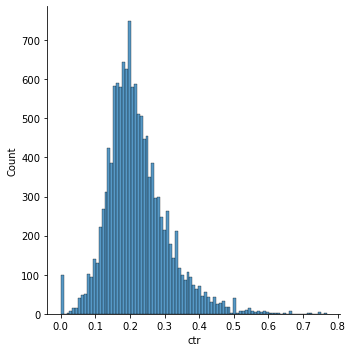

In [3]:
sns.displot(df[df.exp_group == 0].ctr, kde = False)

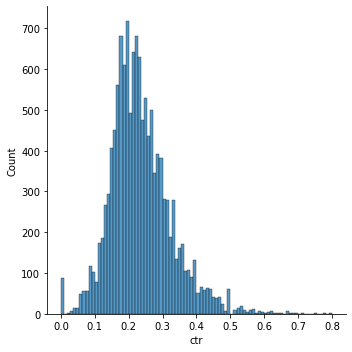

In [4]:
sns.displot(df[df.exp_group == 1].ctr, kde = False)

Видим, что распределения похожи между собой и на нормальное распределение, но есть выбросы в нуле и длинный хвост справа. Такой CTR получается у пользователей, которые еще мало времени провели в приложении. Они еще не успели показать свой реальный CTR. Поэтому будем считать, что CTR у таких пользователей ближе к global CTR. Произведем преобразование CTR

In [5]:
def get_smothed_ctr (user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [6]:
global_ctr = df.like.sum() / df.view.sum()

In [7]:
df['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['like'], x['view'], global_ctr, 5), axis = 1)

In [8]:
df

,user_id,like,view,ctr,exp_group,smothed_ctr
0,26117,5,21,0.238095,1,0.234903
1,138232,5,29,0.172414,1,0.179632
2,49204,10,62,0.161290,1,0.165783
3,49286,7,19,0.368421,1,0.337812
4,145957,54,129,0.418605,1,0.411250
...,...,...,...,...,...,...
25994,3681,6,28,0.214286,0,0.215378
25995,110956,12,63,0.190476,1,0.192757
25996,132567,18,66,0.272727,1,0.269120
25997,30872,25,82,0.304878,1,0.300086


Теперь посмотрим на распределения уже сглаженного CTR

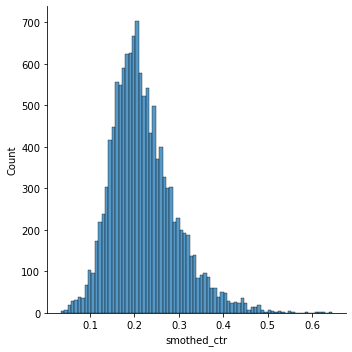

In [9]:
sns.displot(df[df.exp_group == 0].smothed_ctr, kde = False)

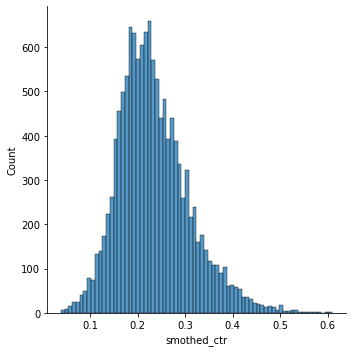

In [10]:
sns.displot(df[df.exp_group == 1].smothed_ctr, kde = False)

Теперь наши распределения больше похожи на нормальное

Сравним доверительные интервалы CTR в двух группах

In [11]:
print(df[df.exp_group == 1].ctr.quantile(0.05)),
print(df[df.exp_group == 1].ctr.mean()),
print(df[df.exp_group == 1].ctr.quantile(0.95))

0.11250880281690143
0.23648646948093194
0.4


In [12]:
print(df[df.exp_group == 0].ctr.quantile(0.05)),
print(df[df.exp_group == 0].ctr.mean()),
print(df[df.exp_group == 0].ctr.quantile(0.95))

0.1034482758620689
0.22195492956578272
0.3846153846153846


Видим, что CTR в 1 группе выше. Проверим нулевую гипотезу о равенстве CTR

Проведем Т-тест для сглаженного CTR

In [13]:
stats.ttest_ind(df[df.exp_group == 0].smothed_ctr, df[df.exp_group == 1].smothed_ctr, equal_var = False)

Ttest_indResult(statistic=-14.27852163637721, pvalue=4.45125763752244e-46)

И проведем тест mannwhitneyu для CTR

In [14]:
stats.mannwhitneyu(df[df.exp_group == 0].ctr, df[df.exp_group == 1].ctr)

MannwhitneyuResult(statistic=75455843.5, pvalue=1.9101702958848542e-50)

В обоих случаях p-values < 0.05, что позволяет отклонить нулевую гипотезу и сделать вывод о статистически значимых различиях в группах

### Проведем контрольную проверку, что новый алгоритм не привел к тому, что сократилось число просмотров у пользователей

Посмотрим на распределения просмотров

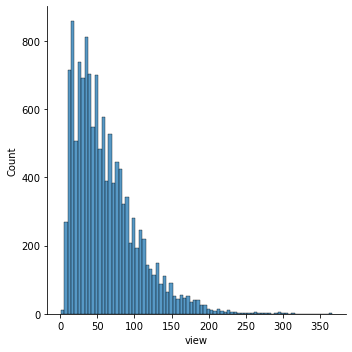

In [15]:
sns.displot(df[df.exp_group == 0].view, kde = False)

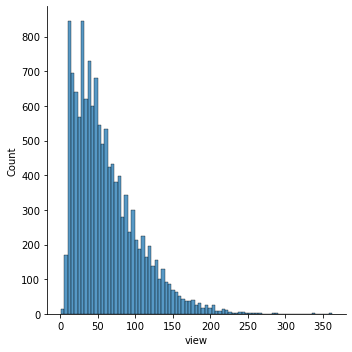

In [16]:
sns.displot(df[df.exp_group == 1].view, kde = False)

Распределения асимметричные, для проведения Т-теста, прологарифмируем наши данные

In [17]:
df['log_view'] = np.log(df.view)

In [18]:
df

,user_id,like,view,ctr,exp_group,smothed_ctr,log_view
0,26117,5,21,0.238095,1,0.234903,3.044522
1,138232,5,29,0.172414,1,0.179632,3.367296
2,49204,10,62,0.161290,1,0.165783,4.127134
3,49286,7,19,0.368421,1,0.337812,2.944439
4,145957,54,129,0.418605,1,0.411250,4.859812
...,...,...,...,...,...,...,...
25994,3681,6,28,0.214286,0,0.215378,3.332205
25995,110956,12,63,0.190476,1,0.192757,4.143135
25996,132567,18,66,0.272727,1,0.269120,4.189655
25997,30872,25,82,0.304878,1,0.300086,4.406719


Посмотрим теперь на распределения логарифмов 

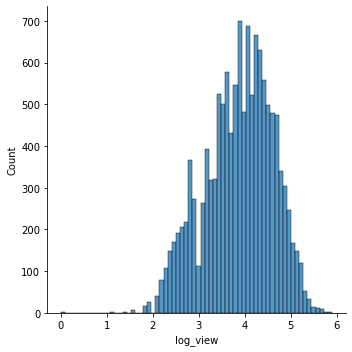

In [19]:
sns.displot(df[df.exp_group == 0].log_view, kde = False)

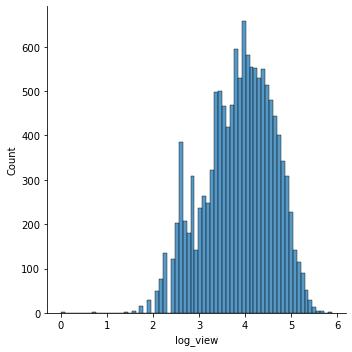

In [20]:
sns.displot(df[df.exp_group == 1].log_view, kde = False)

Не идеально, но уже лучше, проведем Т-тест по логарифмированным просмотрам и тест mannwhitneyu по просмотрам

In [21]:
stats.ttest_ind(df[df.exp_group == 0].log_view, df[df.exp_group == 1].log_view, equal_var = False)

Ttest_indResult(statistic=0.21340400193402262, pvalue=0.8310135327751322)

In [22]:
stats.mannwhitneyu(df[df.exp_group == 0].view, df[df.exp_group == 1].view)

MannwhitneyuResult(statistic=84514942.0, pvalue=0.9717276363684261)

p-value > 0.05, это значит, что наши просмотры не пострадали. Нет значимых отличий по просмотрам в группе 0 и в группе 1

### Вывод:

В результате AB теста были выявлены значимые отличия в группах 0 и 1. Экспериментальная группа 1 показала значимо лучший результат CTR, чем проверочная группа 0.
При этом число просмотров осталось таким же, как до эксперимента. Рекомендуется применить новый алгоритм на всех пользователей.